In [1]:
import pandas as pd #type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

Matplotlib is building the font cache; this may take a moment.


In [2]:
def clean_data(df, column):
        df[column] = pd.to_numeric(df[column], errors='coerce') 
        invalid_values = df[column].isnull() | ~df[column].apply(lambda x: isinstance(x, (int, float))) | (df[column] < 0) | (df[column] > 1200)
        df.loc[invalid_values, column] = None

#initially tried to clean the data  using the "iteritems" function but ran into errors, so had ChatGPT give me an alternative. Also used the "to_numeric" function as the data was not initially read in as numeric values and was not compatible with the logic operators.
#the above code was written by chatGPT as I was not familiar with the python syntax for data cleaning, however the removal of values less than 0 and greater than 1200 was implemented by me as I noticed that the ETF price did not exceed three digits at any point in the data, other than when values were skewed.
#this portion of the code eliminated null values, non-numeric values, and incorrect values from the data.
    
        df[column].fillna(method='ffill', inplace=True)

#this portion of the code fills the deleted index with the value of the previous index since they should be roughly equal and the difference will be irrelevant due to the size of the dataframe.

<ipython-input-2-b2a61fdd7ca1>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(method='ffill', inplace=True)
<ipython-input-2-b2a61fdd7ca1>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='ffill', inplace=True)
<ipython-input-2-b2a61fdd7ca1>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will ch

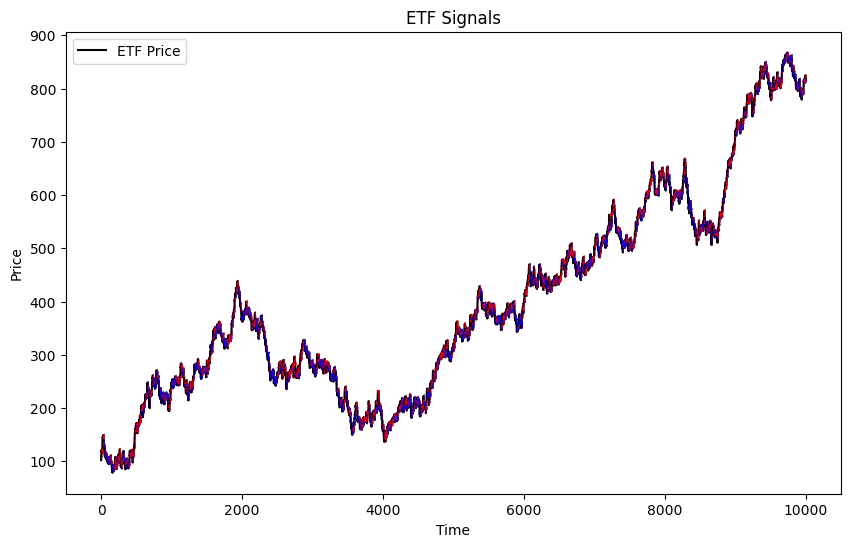

In [3]:
data = pd.read_csv("price_data.csv") #converts excel file to dataframe
clean_data(data, "Stock A")          #because the clean_data function takes in arguments of both the dataframe and the column, I needed to apply the function to all columns in the data frame.
clean_data(data, "Stock B")
clean_data(data, "Stock C")
clean_data(data, "Stock D")
clean_data(data, "ETF")

def signal(df, etf):   #takes in parameters dataframe and etf so that this code can be applied to any dataframe that contains data for multiple underlying assets and an ETF.
    signals = []            #initializes a list for the signals
    correlation_dict = {}   #initializes a dictionary for the correlation of the assets relative to the ETF
    for asset in df.columns:
        if asset != etf:    #iterates through the correlation of each asset relative to the ETF, but not the etf itself since the correlation is known to be 1
            correlation = np.corrcoef(df[asset], df[etf])[0, 1]    #built in correlation function, computes correlation coefficeint between an asset and the ETF as a matrix.
            correlation_dict[asset] = correlation                  #adds the correlation coefficient of the asset to the correlation list
            diff = df[asset].diff()                          #computes the difference between a price at an index and the price at the previous index
            gain = diff.apply(lambda x: x if x > 0 else 0)   #lists difference as a gain if diff > 0
            loss = diff.apply(lambda x: x if x < 0 else 0)   #lists difference as a loss if diff < 0
            ema_gain = gain.ewm(span=14).mean()              #computes average exponential weighted average for the past 14 indexes where there was a gain.
            ema_loss = loss.ewm(span=14).mean()              #computes average exponential weighted average for the past 14 indexes where there was a loss.
            rs = ema_gain/ema_loss                           #computes relative strength using the relative strength formula
            rsi = 100 - (100/(1 + rs))                       #computes relative strength index using the rsi formula.

            for i in range(1, len(df)):                         #iterates through each index in the dataframe
                if correlation > 0.5 and rsi.iloc[i] > 70:      
                    signals.append((asset, -1, i))              #indicates sell, appends a tuple of the asset, the signal, and the index to "signals" list
                elif correlation > 0.5 and rsi.iloc[i] < 30:
                    signals.append((asset, 1, i))               #indicates buy, appends a tuple of the asset, the signal, and the index to "signals" list
                elif correlation < -0.5 and rsi.iloc[i] > 70:
                    signals.append((asset, 1, i))               #indicates buy, appends a tuple of the asset, the signal, and the index to "signals" list
                elif correlation < -0.5 and rsi.iloc[i] < 30:
                    signals.append((asset, -1, i))              #indicates sell, appends a tuple of the asset, the signal, and the index to "signals" list
                else:
                    signals.append((asset, 0, i))               #indicates no action, appends a tuple of the asset, the signal, and the index to "signals" list
    return signals
                
                                       
signals = signal(data, "ETF")           #applies "signal" function to the given dataframe

prices = data["ETF"]                    #plots prices from ETF data
plt.figure(figsize =(10,6))             #used ChatGPT for these two functions, don't have much experience with matplotlib
plt.plot(prices, label = "ETF Price", color = "black")
 
up = "\u2191"                           #code for up arrow, used chatgpt for this.
down = "\u2193"                         #code for down arrow, used chatgpt for this.

for signal in signals:                  #iterates through signals list 
    if signal[1] == 1:
        plt.annotate(up, (signal[2], prices.iloc[signal[2]]), color = "blue", fontsize = 2, ha="center")     #plots up arrow if the signal is 1. Because "signals" is composed of tuples, I used indexes to locate the signal and to plot it at the correct index.
    if signal[1] == -1:
        plt.annotate(down, (signal[2], prices.iloc[signal[2]]), color = "red", fontsize = 2, ha="center")    #plots down arrow if the signal is -1. Used chatgpt to help parameterize the annotate function.

plt.title("ETF Signals")                #labels the graph
plt.xlabel("Time")                      #labels the x-axis
plt.ylabel("Price")                     #labels the y-axis
plt.legend()    
plt.show()


In [4]:
#this block of code computes the value of the cumulative return as a percentage. 
buy = None                                     #initializes the buy value                                 
returns = []                                   #initializes the returns

for signal in signals:                          #iterates through the signals
    current_price = data["ETF"].iloc[signal[2]] #sets the current price equal to the index of the ETF
    if signal[1] == 1:                          
        buy = current_price                     #buys ETF at the current price when the signal indicates to do so
    elif signal[1] == -1 and buy is not None:   #sells ETF under the condition that the ETF is currently owned 
        sell = current_price                    #sells at the current price of the ETF
        return_val = (sell - buy)/buy           #calculates the profit from the sale. A negative profit indicates a loss.
        returns.append(return_val)              #adds the return value to the "returns" list
        buy = None                              #resets the buy value to None, since the ETF is no longer owned.

total_returns = np.prod(1 + np.array(returns) / 100) - 1     #Formula to calculate the total returns. From ChatGPT
print(f"Final Total Return: {total_returns * 100:.2f}%")     #prints the final returns as a single percentage. Also from ChatGPT

Final Total Return: 7.63%


This strategy first measures the correlation of the price of each underlying asset to the price of the etf itself. The logic behind finding correlation coefficients for each asset is to filter out assets with low correlation as their price fluctuations will be less related to the price fluctuations of the etf. The strategy itself is to find the relative strength index (rsi) for each asset to indicate which assets could be overbought or oversold. To determine the action signals, I iterated through the prices of each asset and implemented buy signals at high correlation and low rsi and at high inverse correlation and high rsi, and implemented sell signals at high correlation and high rsi and at high inverse correlation and low rsi. Both the rsi and correlation criteria must be met for a trade to be signaled, otherwise the signal is 0 indicating no action. The strategy yielded a total return of 7.63% relative to the returns of the ETF itself (since the return only takes into account the differences in the buy and sell prices), so this strategy is beneficial. 